# 1. Librerias y Funciones

#### 1.1. Librerias

In [24]:
import cv2
# print("OpenCV version:", cv2.__version__)
import tensorflow as tf
# print("TensorFlow version:", tf.__version__)

# Para rellenar los huevos dentros de las imagenes
from scipy import ndimage

import sklearn 
# print("Sklearn version:", sklearn.__version__)
import skimage
# print("Skimage version:", skimage.__version__)
import numpy as np
# print("Numpy version:", np.__version__)
import pandas as pd
# print("Pandas version:", pd.__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

import plotly.express as px
import seaborn as sns

import cufflinks as cf

#### 1.2. Funciones Auxiliares

In [25]:
from funciones_auxiliares.aux_01 import img_rgb_plot, img_gray_plot, show_img

# 2. Procesamiento de Imagenes

### 2.1. Cargando Imagenes

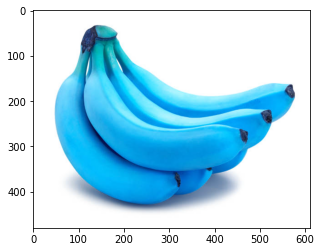

In [26]:
img = cv2.imread("../imagenes/pruebas/banana-ejemplo.jpg") # importamos la foto en matriz de RGB
show_img(img)

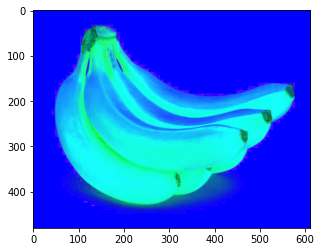

In [27]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
show_img(hsv)

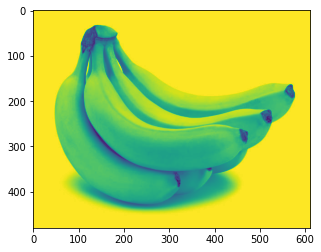

In [28]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
show_img(img_gray)

### 2.2. Algoritmo de OTSU para recordar objeto de una imagen

In [29]:
# aahora hallamos el valor del umbral mendiante el metodo de OTSU que ya viene implementado en el cv2
umbral,_=cv2.threshold(img_gray,0,255,cv2.THRESH_OTSU)
umbral

204.0

204.0


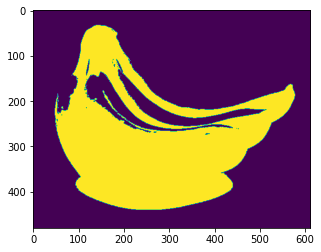

In [30]:
binary = np.uint8(img_gray<umbral)*255 # si un valor es mejor que 200 me dara 1. lo multiplico por 255 para hacer una imagen de contraste en clave de dos valores lo que no me darra 0
print(umbral)
show_img(binary)

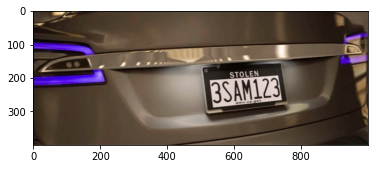

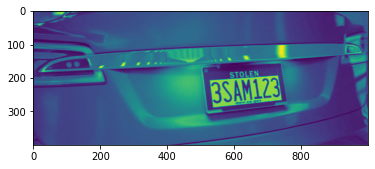

97.0


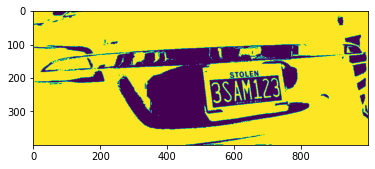

In [31]:
img2 = cv2.imread("../imagenes/matriculas/placa1.jpg") # importamos la foto en matriz de RGB
show_img(img2)

img2_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY) # Pasamos la imgaen a blanco y negro en scala de grises
show_img(img2_gray)

umbral,_=cv2.threshold(img2_gray,0,255,cv2.THRESH_OTSU)
print(umbral)

binary = np.uint8(img2_gray<umbral)*255 
# si un valor es mejor que 200 me dara 1. lo multiplico por 255 para hacer una imagen de contraste en clave de dos valores lo que no me darra 0
show_img(binary)

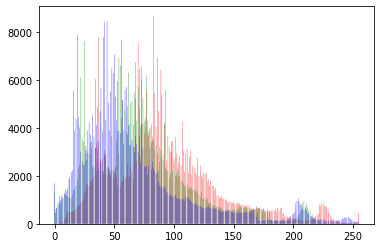

In [32]:
rojo = img2[:,:,0].flatten()
verde = img2[:,:,1].flatten()
azul = img2[:,:,2].flatten()

plt.hist(rojo,bins=1000,histtype='stepfilled',color='red')
plt.hist(verde,bins=1000,histtype='stepfilled',color='green')
plt.hist(azul,bins=1000,histtype='stepfilled',color='blue')

plt.show()

Si no podemos hacer una segmentacion apropiada en Escalas de Grises, usaremos la mezcla de Gausianos. 

### 2.3. Recortando objetos del fondo usando mascara

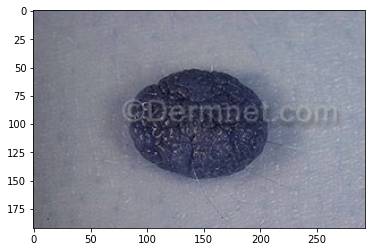

In [33]:
img3 = cv2.imread("../imagenes/imagenes_ejemplo/000078.jpg") 
# importamos la foto en matriz de RGB
show_img(img3)

102.0
n objetos: 22


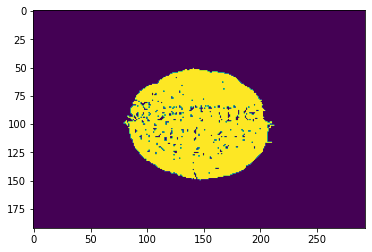

In [34]:
img3_gray = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY) # Pasamos la imgaen a blanco y negro en scala de grises

umbral,_=cv2.threshold(img3_gray,0,255,cv2.THRESH_OTSU)
print(umbral)

mascara = np.uint8(img3_gray<umbral)*255 

output = cv2.connectedComponentsWithStats(mascara,4,cv2.CV_32S)
# print(output)

# Nos dice que hay dos objetos
cantidad_objetos = output[0]
print(f"n objetos: {cantidad_objetos}")

# Matriz con los objetos en los registros
#  como tengo varios objetos me va a dar una 
labels = output[1]
# print(labels)

# La columna 4 de stats esta diciendo cuando pixeles existen en ese grupo
stats = output[2]
# print(stats)

# cambiamos la mascara por el fondo que es el objeto mas grande y si le sumo 1
# me dara el siguiente objeto, en este caso el platano
mascara = np.argmax(stats[:,4][1:])+1==labels
show_img(mascara)

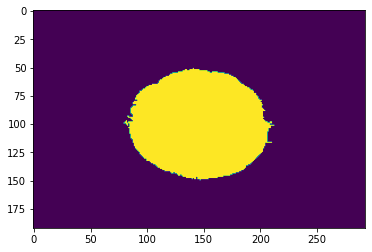

In [35]:
# Con este metodo rellenamos la imagen, el objeto que estamos senalando
mascara = ndimage.binary_fill_holes(mascara).astype(int)
# marcara tendra valores del 0 para el fondo 1 para el objeto
show_img(mascara)

#### 2.4. Medicion area y perimetro del objeto

In [36]:
# vamos a usar ahora la mascara, entre 0 y 255 siguiente el estandar 
mascara_gray = np.uint8(mascara*255)
# print(mascara_gray)
# show_img(mascara_gray)

In [37]:
_,countours,_ = cv2.findContours(mascara_gray, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contorno = countours[0]

perimetro = cv2.arcLength(contorno,True) # Si el objeto es cerrado True, si no False
print(perimetro)

area = cv2.contourArea(contorno)
print(area)

437.3452328443527
9167.5


#### 2.5. Convex Hull

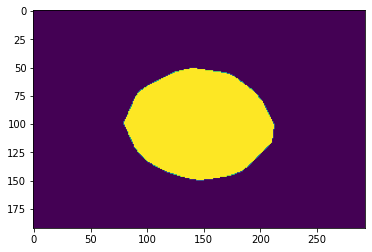

In [38]:
convex_hull = cv2.convexHull(contorno)

puntos_convex_hull = convex_hull[:,0,:]

m,n = mascara_gray.shape
ar=np.zeros((m,n))
mascara_convex = np.uint8(cv2.fillConvexPoly(ar,puntos_convex_hull,1))
show_img(mascara_convex)

#### 2.6. Bounding Box rotado

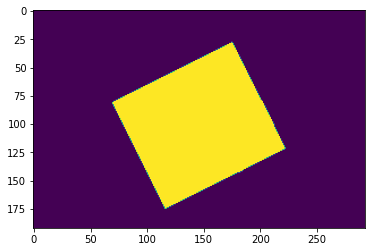

In [44]:
rectangulo = cv2.minAreaRect(contorno)
box = np.int0(cv2.boxPoints(rectangulo))

mascara_box = np.uint8(cv2.fillConvexPoly(ar,box,1))
show_img(mascara_box)

#### 2.7. Bounding Box recto

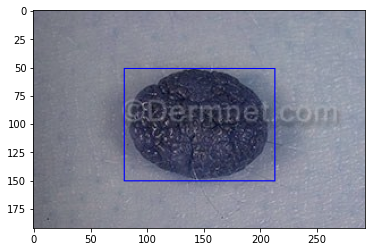

In [40]:
x,y,w,h = cv2.boundingRect(contorno)
imag3_rectangulo = cv2.rectangle(img3,(x,y),(x+w,y+h),(0,0,255),1)
show_img(imag3_rectangulo)

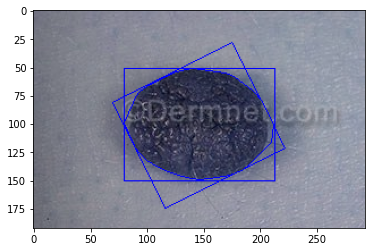

In [50]:
_,countours,_ = cv2.findContours(mascara_convex, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

a = cv2.drawContours(img3,countours,-1,(0,0,255),1)

_,countours,_ = cv2.findContours(mascara_box, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

a = cv2.drawContours(img3,countours,-1,(0,0,255),1)

show_img(a)

#### 2.8 Segmentando el objeto a color

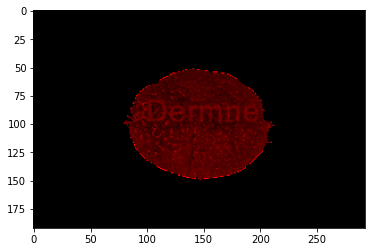

In [59]:
segColor = np.zeros((m,n,3)).astype('uint8')
segColor[:,:,0] = np.uint8(img3[:,:,0] * mascara)
segColor[:,:,0] = np.uint8(img3[:,:,1] * mascara)
segColor[:,:,0] = np.uint8(img3[:,:,2] * mascara)

show_img(segColor)